In [2]:
import numpy as np
import extq
import matplotlib.pyplot as plt
import pyemma
import glob
import sys
import importlib
import gc
import sklearn
from sklearn import metrics

In [3]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../../")
import util
import kde

# Load feature 2 data (salt bridges)

In [4]:
with np.load("../../data/raw_feat/feat2_raw.npz", allow_pickle=True) as f:
    data = f["arr_0"]

In [5]:
print(len(data))
print(data[0].shape)

1295
(3000, 60)


In [6]:
data_arr = np.concatenate(data)
print(data_arr.shape)

(6580000, 60)


Load CV data

In [7]:
with np.load("../../data/raw_feat/cv_dist_spin.npz", allow_pickle=True) as f:
    cvs = f["arr_0"]

In [8]:
cvs.shape

(6580000, 2)

In [9]:
traj_lens = [len(traj) for traj in data]
traj_inds = []
subtot = 0
for length in traj_lens[:-1]:
    subtot += length
    traj_inds.append(subtot)

In [10]:
cv_trajs = np.split(cvs, traj_inds)

# Averages/distributions of salt bridge distances 

In [11]:
# salt bridges used for ABMD (Cz-Cg distances)
sb0 = 30  # R217 - D129
sb1 = 40  # R223 - D186
sb2 = 43  # R226 - D136
sb3 = 48  # R229 - D129
sb4 = 58  # R232 - D186
sbs = (sb0, sb1, sb2, sb3, sb4)

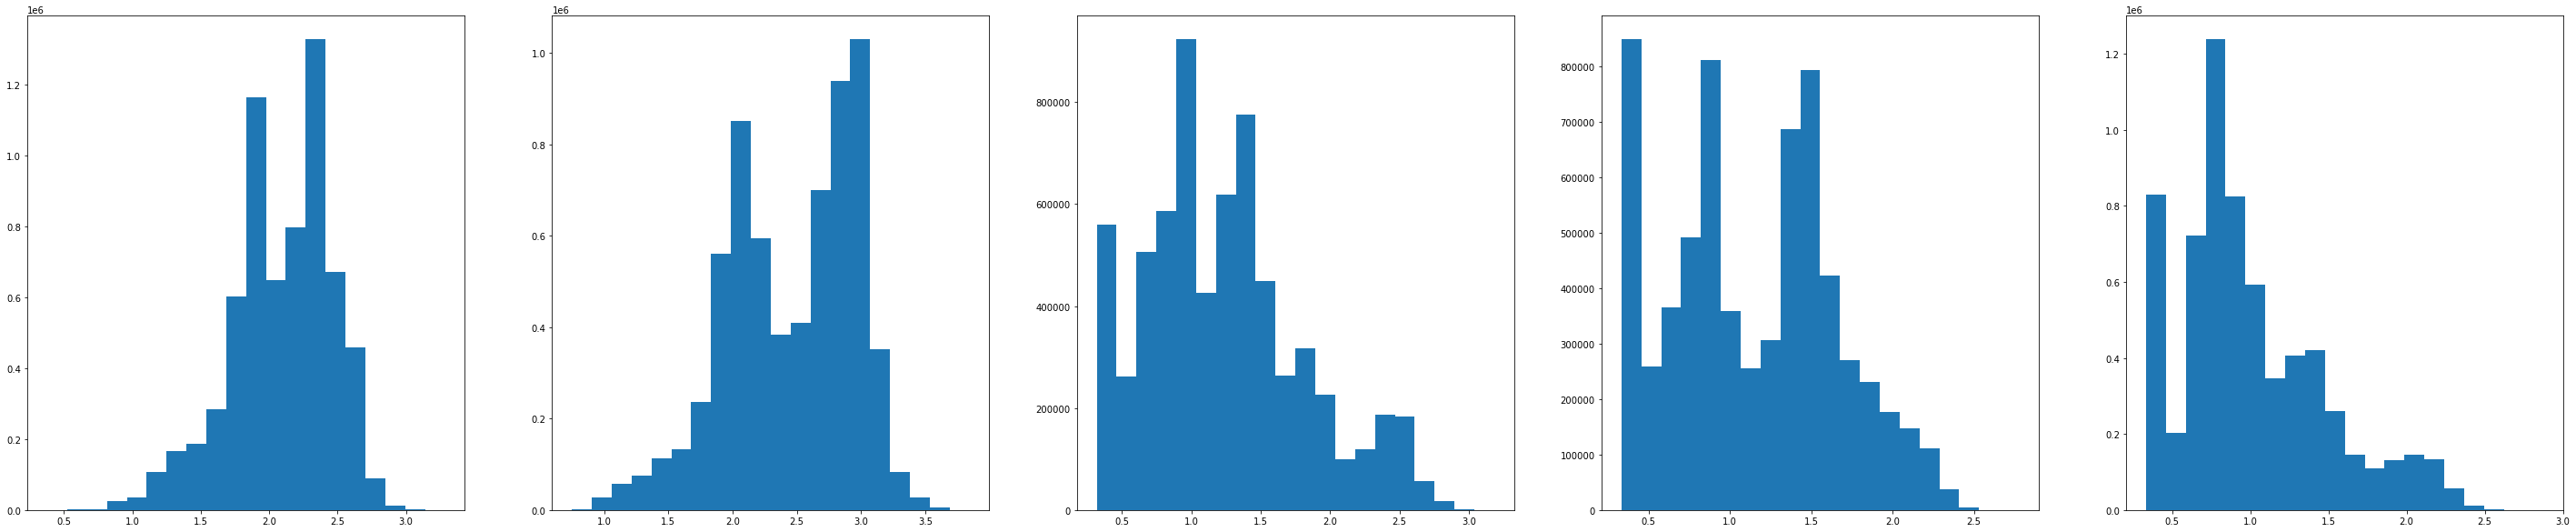

In [34]:
f, axs = plt.subplots(1, 5, figsize=(50, 10))
for ax, idx in zip(axs, sbs):
    ax.hist(data_arr[:, idx], bins=20)

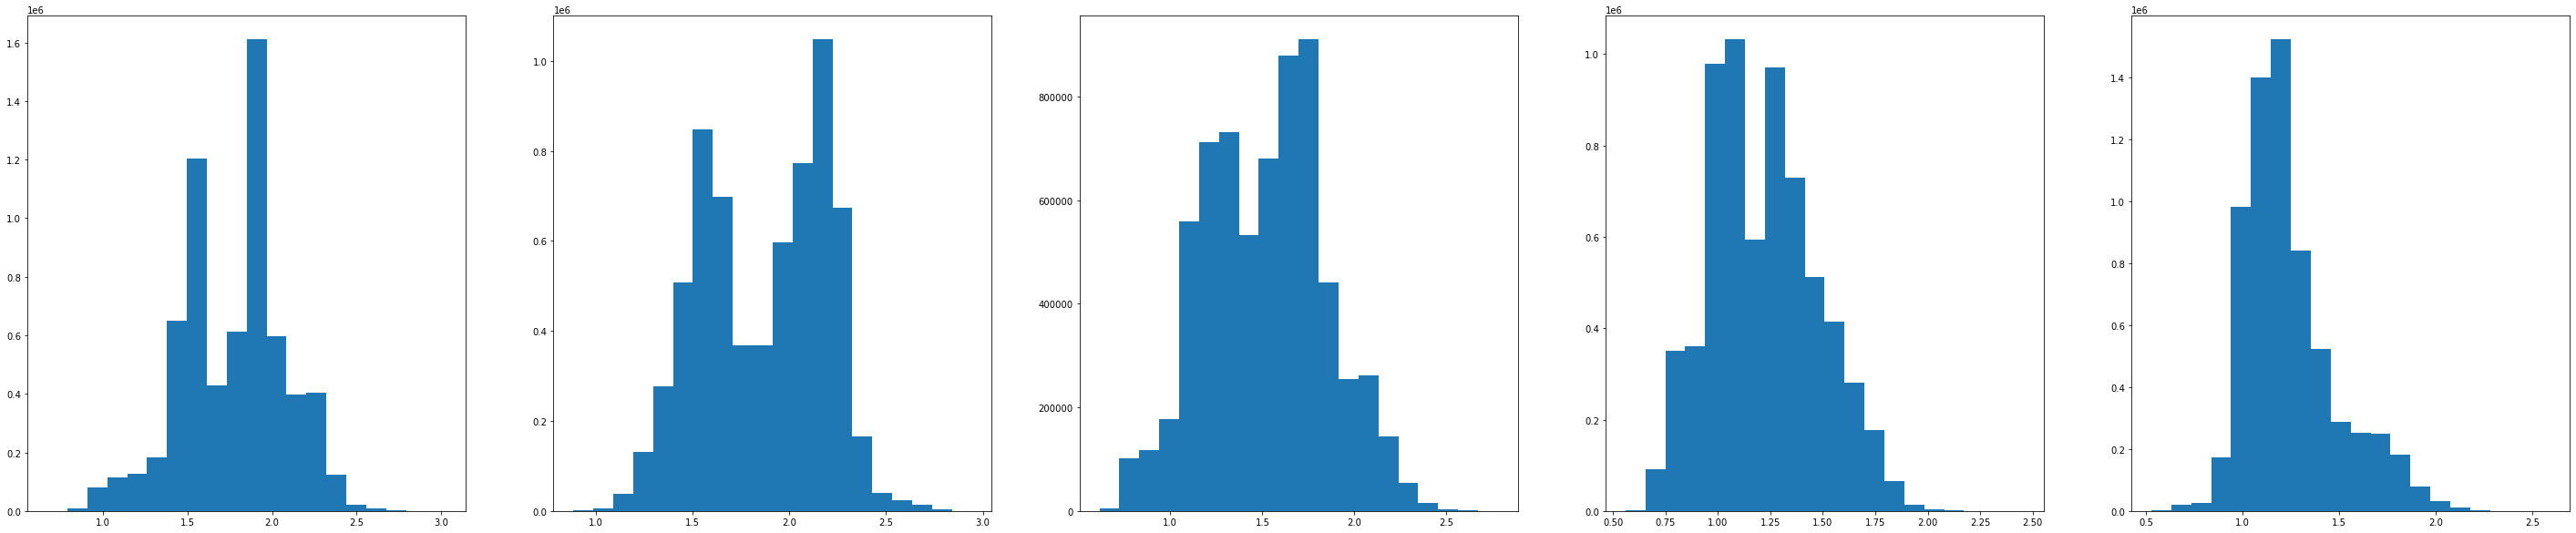

In [35]:
# compare vs. distributions of Calpha distances
f, axs = plt.subplots(1, 5, figsize=(50, 10))
for ax, idx in zip(axs, sbs):
    ax.hist(data_arr[:, idx - 30], bins=20)

Some similarities (e.g. sb0, sb1) but not exactly

## plot against translocation/spin cvs 

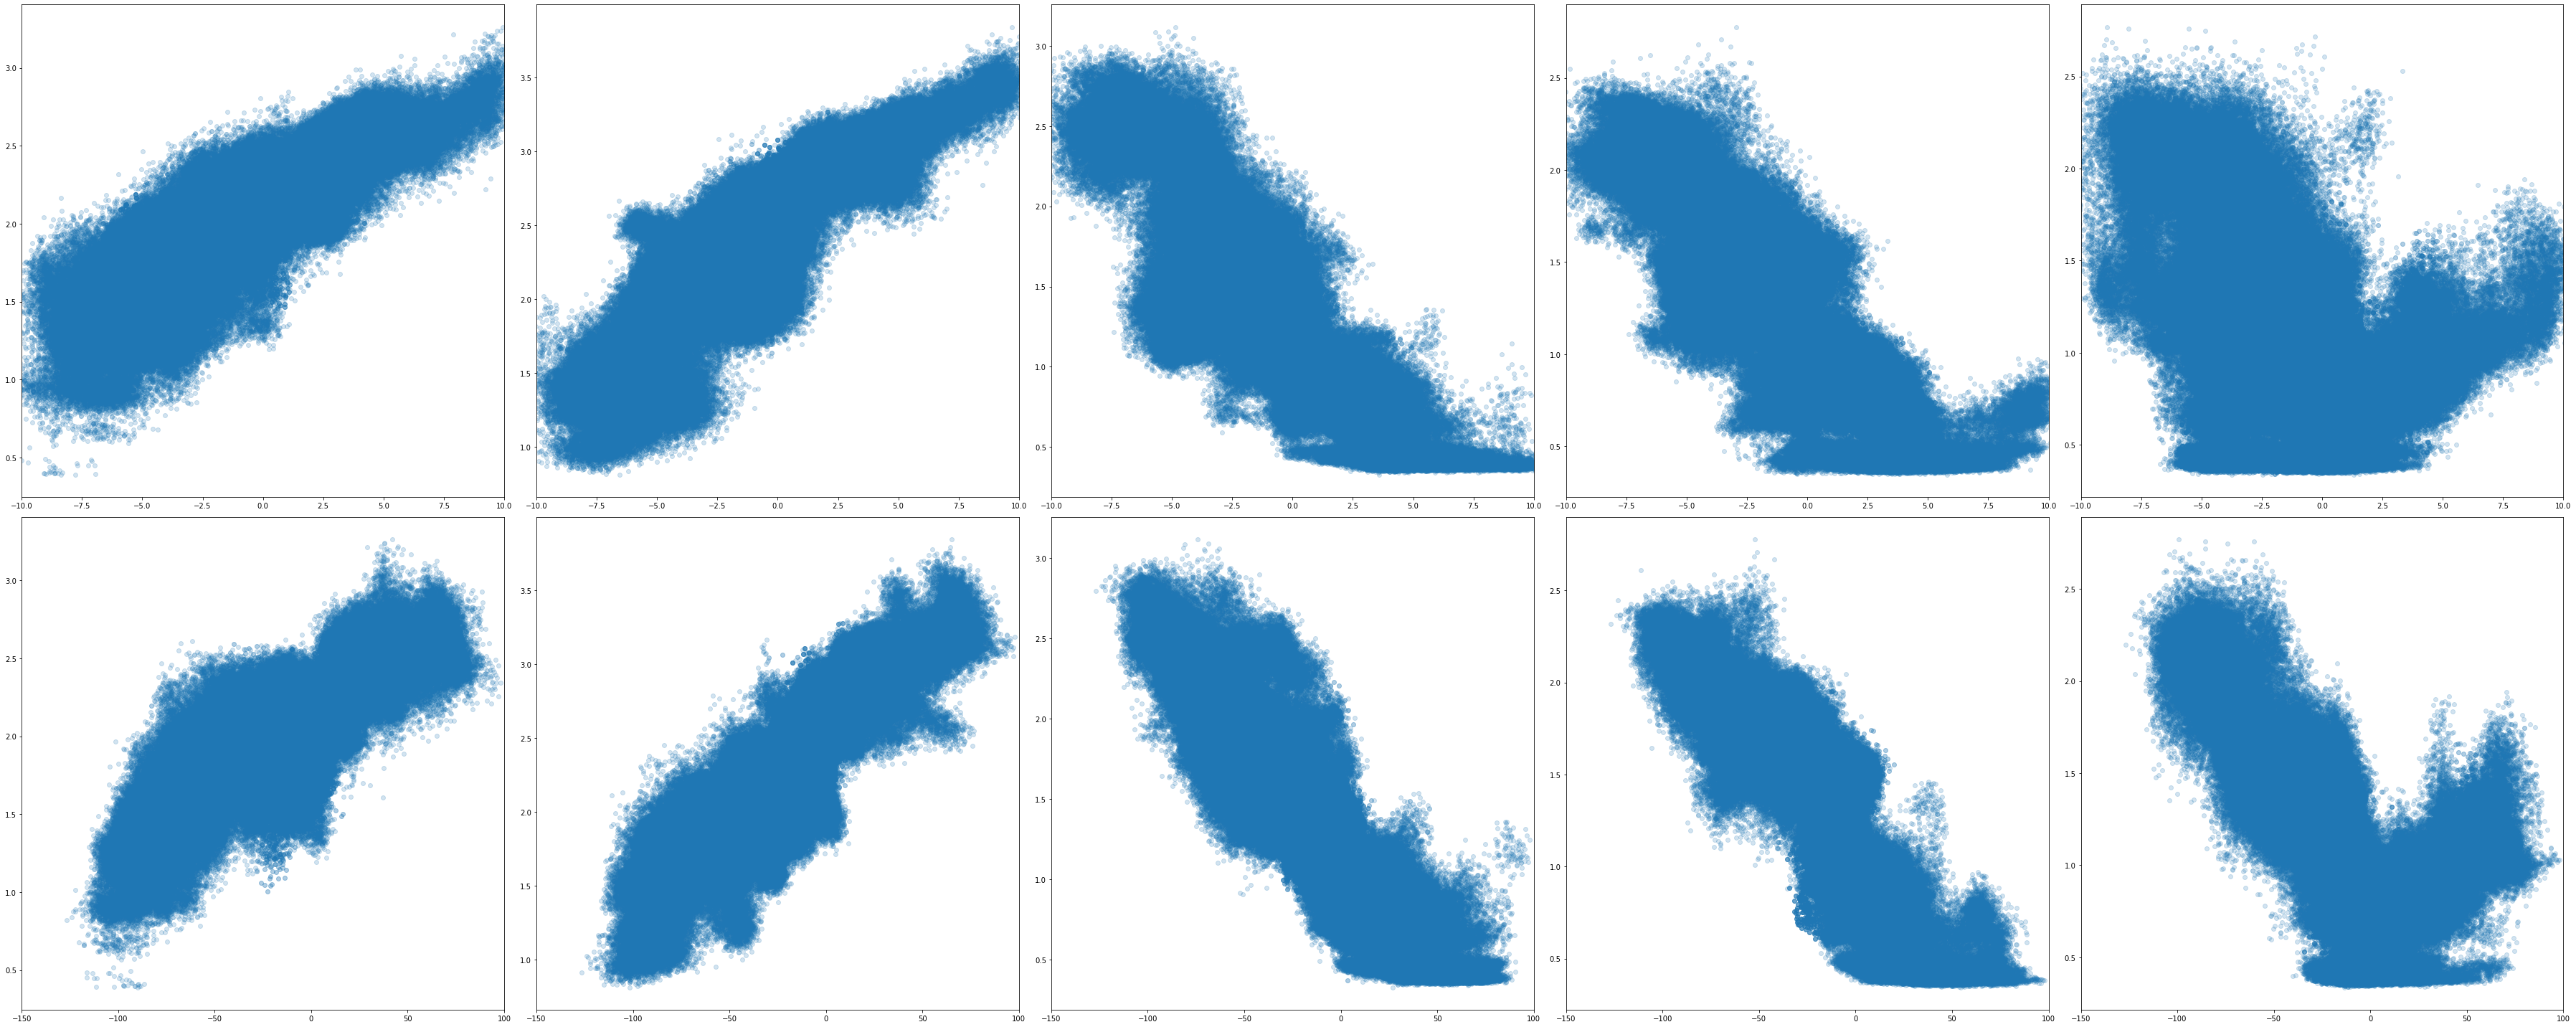

In [37]:
f, axs = plt.subplots(2, 5, figsize=(50, 20))
for ax, idx in zip(axs[0], sbs):
    ax.scatter(cvs[::10, 0], data_arr[::10, idx], alpha=0.2)
    ax.set_xlim([-10, 10])
for ax, idx in zip(axs[1], sbs):
    ax.scatter(cvs[::10, 1], data_arr[::10, idx], alpha=0.2)
    ax.set_xlim([-150, 100])

f.tight_layout()

## salt bridges which measure average distance from to each negative donor (D129, D136, D183, D186)

In [12]:
# sb_avgs_0 = np.mean(data_arr[:,30:60:6], axis=1)
# sb_avgs_1 = np.mean(data_arr[:,31:61:6], axis=1)1
sb_avgs = [np.mean(data_arr[:, 30 + i : 60 + i : 6], axis=1) for i in (0, 1, 4, 5)]

In [20]:
data_arr[:, 30:60:6].shape

(6580000, 5)

In [30]:
sb_avgs[0].shape

(6580000,)

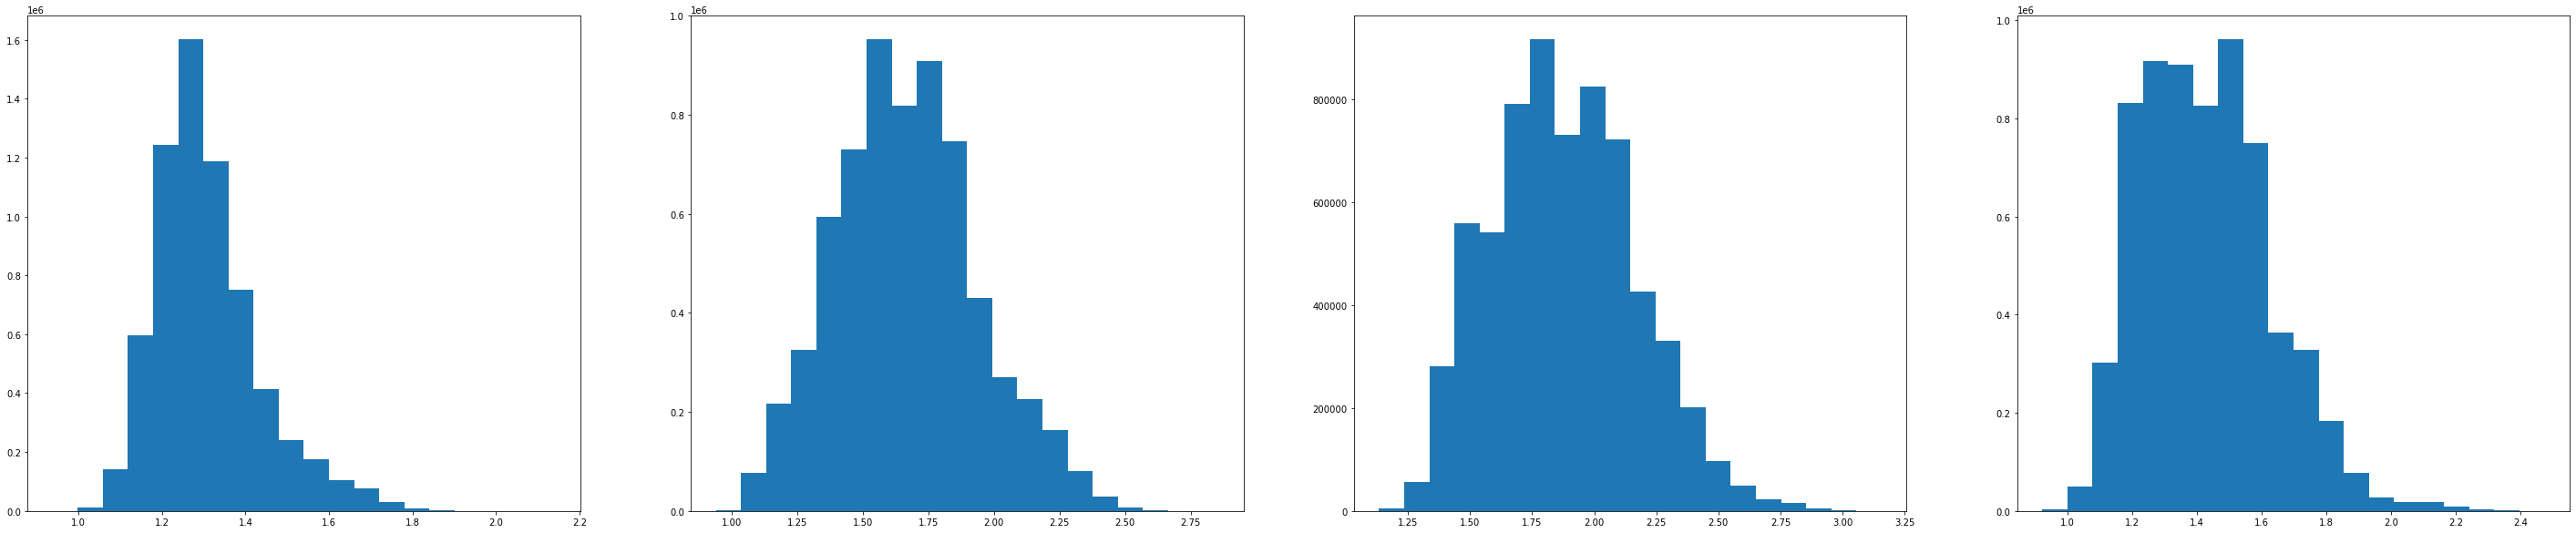

In [31]:
f, axs = plt.subplots(1, 4, figsize=(50, 10))
for data, ax in zip(sb_avgs, axs):
    ax.hist(data, bins=20)

Not that good - all singly peaked

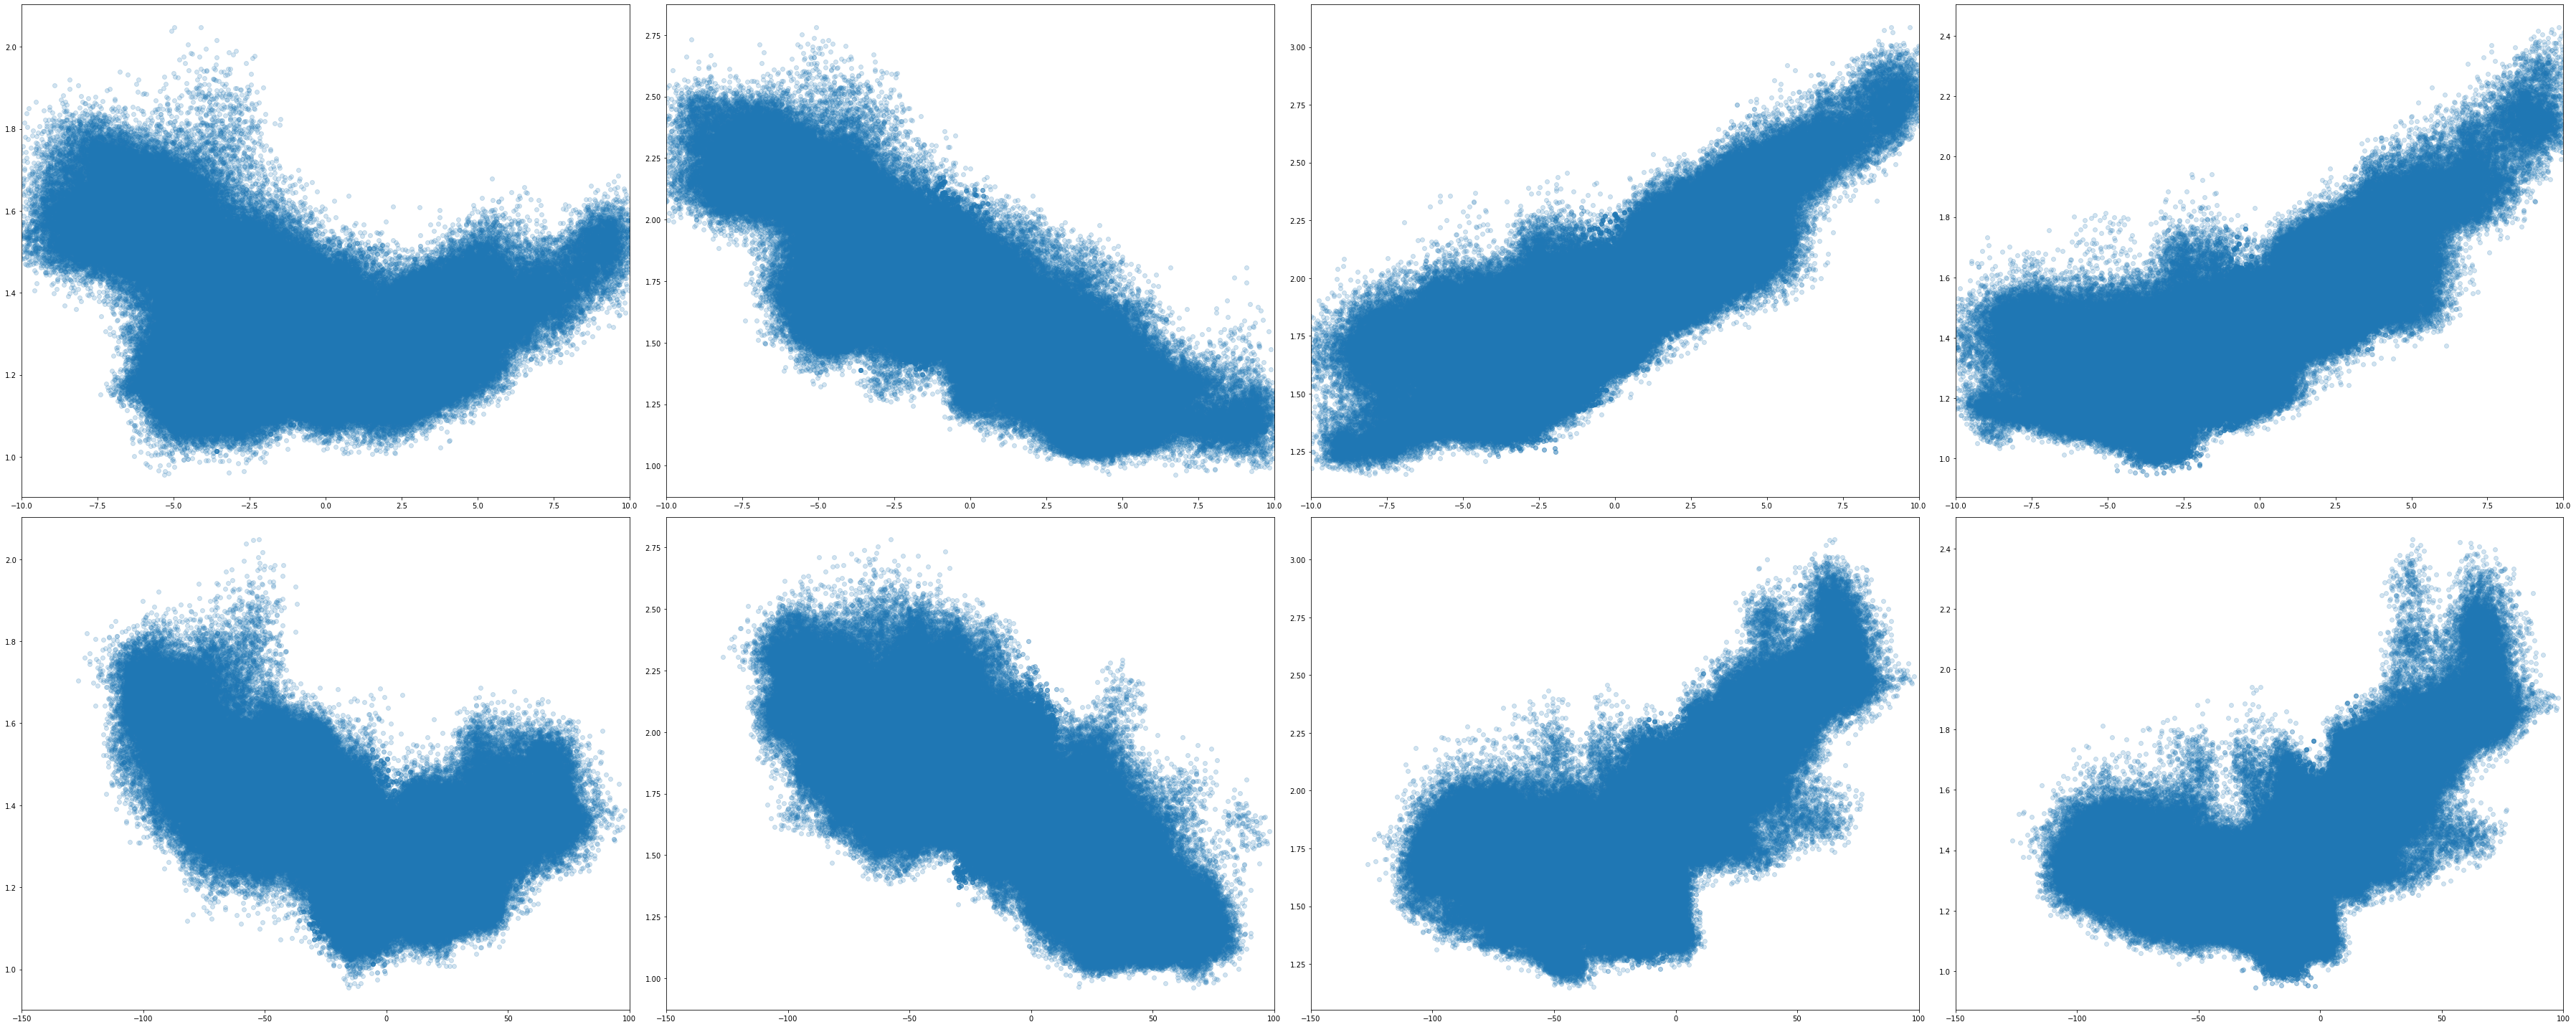

In [32]:
f, axs = plt.subplots(2, 4, figsize=(50, 20))
for ax, data in zip(axs[0], sb_avgs):
    ax.scatter(cvs[::10, 0], data[::10], alpha=0.2)
    ax.set_xlim([-10, 10])
for ax, data in zip(axs[1], sb_avgs):
    ax.scatter(cvs[::10, 1], data[::10], alpha=0.2)
    ax.set_xlim([-150, 100])

f.tight_layout()

# States and averages 

In [13]:
dist = cvs[:, 0]
rot = cvs[:, 1]

# centers of states based off initial crystal structure/homology models
# ellipse centered at (-8.919, -109.9) with radii 0.632 and 9.8 for down - state
downmin_ids = (
    (((dist + 8.919) / 0.632) ** 2 + ((rot + 109.9) / 9.8) ** 2) < 1
).nonzero()[0]

# ellipse centered at (-4.174 , -50.8) with radii 0.574 and 8.21 (1 sigma in each direction) for down state
down_ids = ((((dist + 4.174) / 0.574) ** 2 + ((rot + 50.8) / 8.21) ** 2) < 1).nonzero()[
    0
]

# ellipse centered at (0, 0) with radii 0.460 and 2.9 for up state
up_ids = (((dist / 0.460) ** 2 + (rot / 2.9) ** 2) < 1).nonzero()[0]

# ellipse centered at (4.535, 43.7) with radii 0.632 and 2.9 for up+ state
upplus_ids = (
    (((dist - 4.535) / 0.632) ** 2 + ((rot - 43.7) / 4.0) ** 2) < 1
).nonzero()[0]

In [48]:
mask = np.ones(len(cvs), dtype=bool)
mask[downmin_ids] = False
mask[down_ids] = False
mask[up_ids] = False
mask[upplus_ids] = False

# len(**_ids) is number of points in each state
downmin = data_arr[downmin_ids]
down = data_arr[down_ids]
up = data_arr[up_ids]
upplus = data_arr[upplus_ids]
other = data_arr[mask]

# split CV data
downmin_cvs = cvs[downmin_ids]
down_cvs = cvs[down_ids]
up_cvs = cvs[up_ids]
upplus_cvs = cvs[upplus_ids]
other_cvs = cvs[mask]

In [49]:
assert (len(downmin) + len(down) + len(up) + len(upplus) + len(other)) == len(cvs)
print(f"Number of down- structures: {len(downmin)}")
print(f"Number of down structures:  {len(down)}")
print(f"Number of up structures:    {len(up)}")
print(f"Number of up+ structures:   {len(upplus)}")
print(f"Number of other structures: {len(other)}")

Number of down- structures: 1536
Number of down structures:  56676
Number of up structures:    62403
Number of up+ structures:   54524
Number of other structures: 6404861


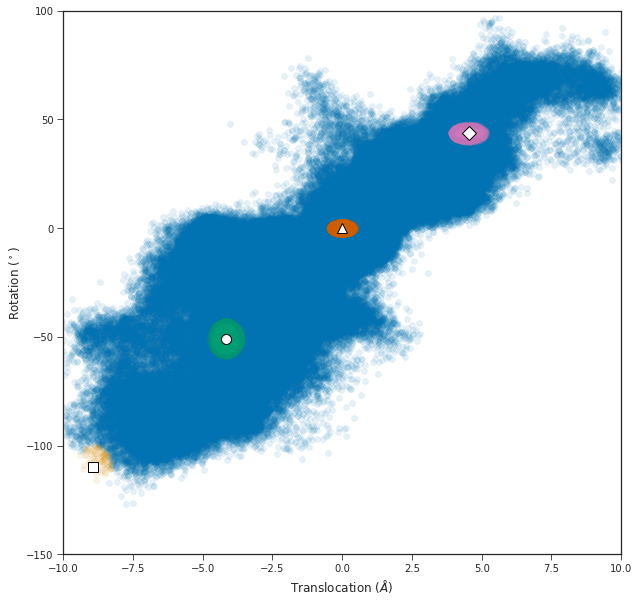

In [104]:
f, ax = plt.subplots(figsize=(10, 10))
for cv_group in (other_cvs, downmin_cvs, down_cvs, up_cvs, upplus_cvs):
    ax.scatter(*cv_group[::20].T, alpha=0.1)
util.format_cvs(ax)

## down minus state 

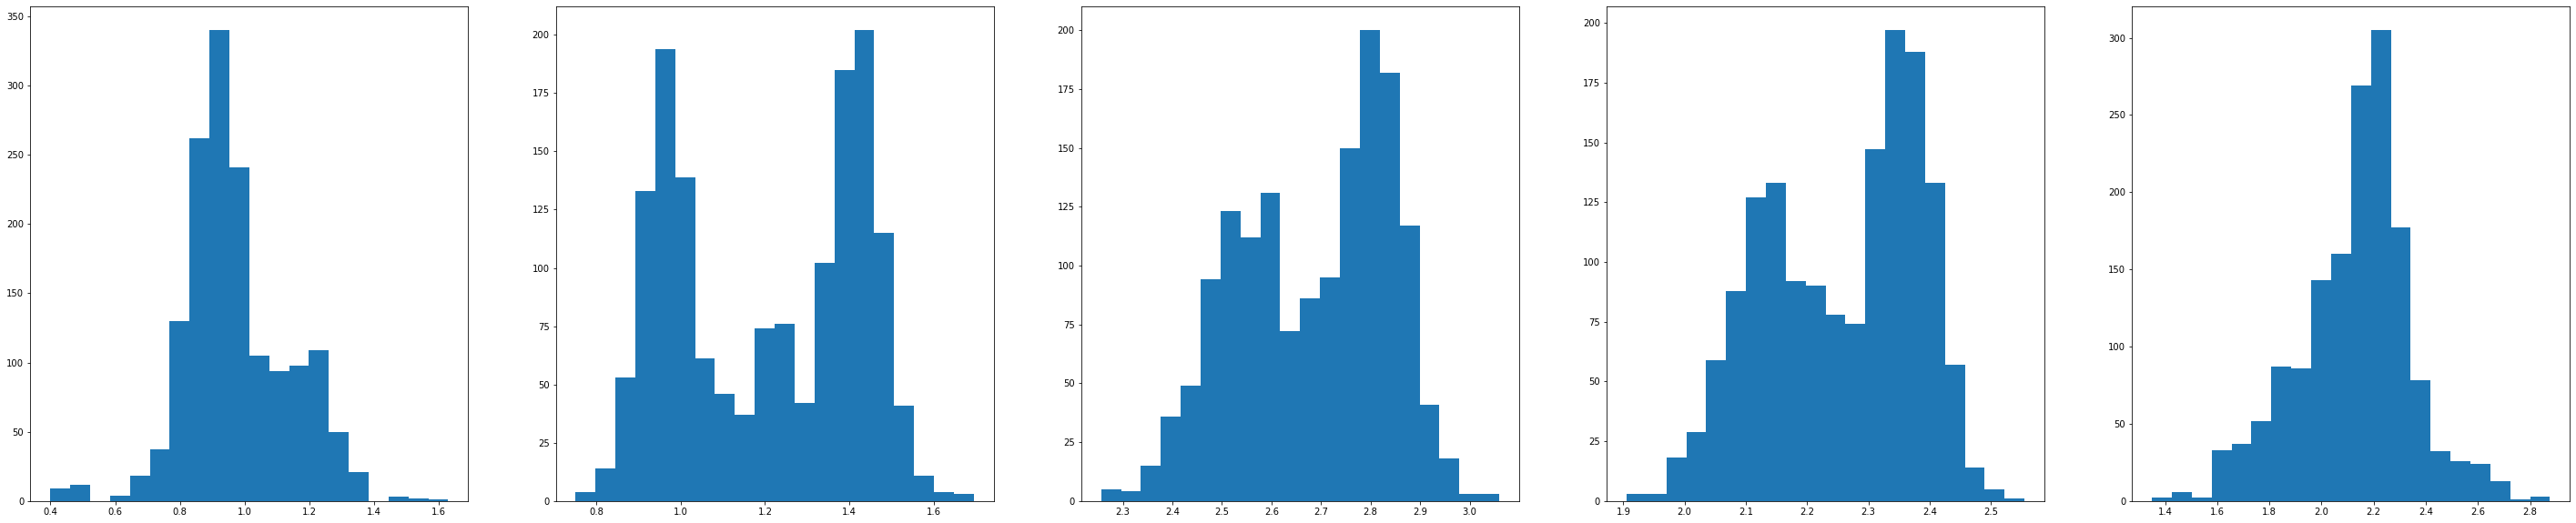

In [64]:
f, axs = plt.subplots(1, 5, figsize=(50, 10))
for ax, idx in zip(axs, sbs):
    ax.hist(downmin[:, idx], bins=20)

## down state 

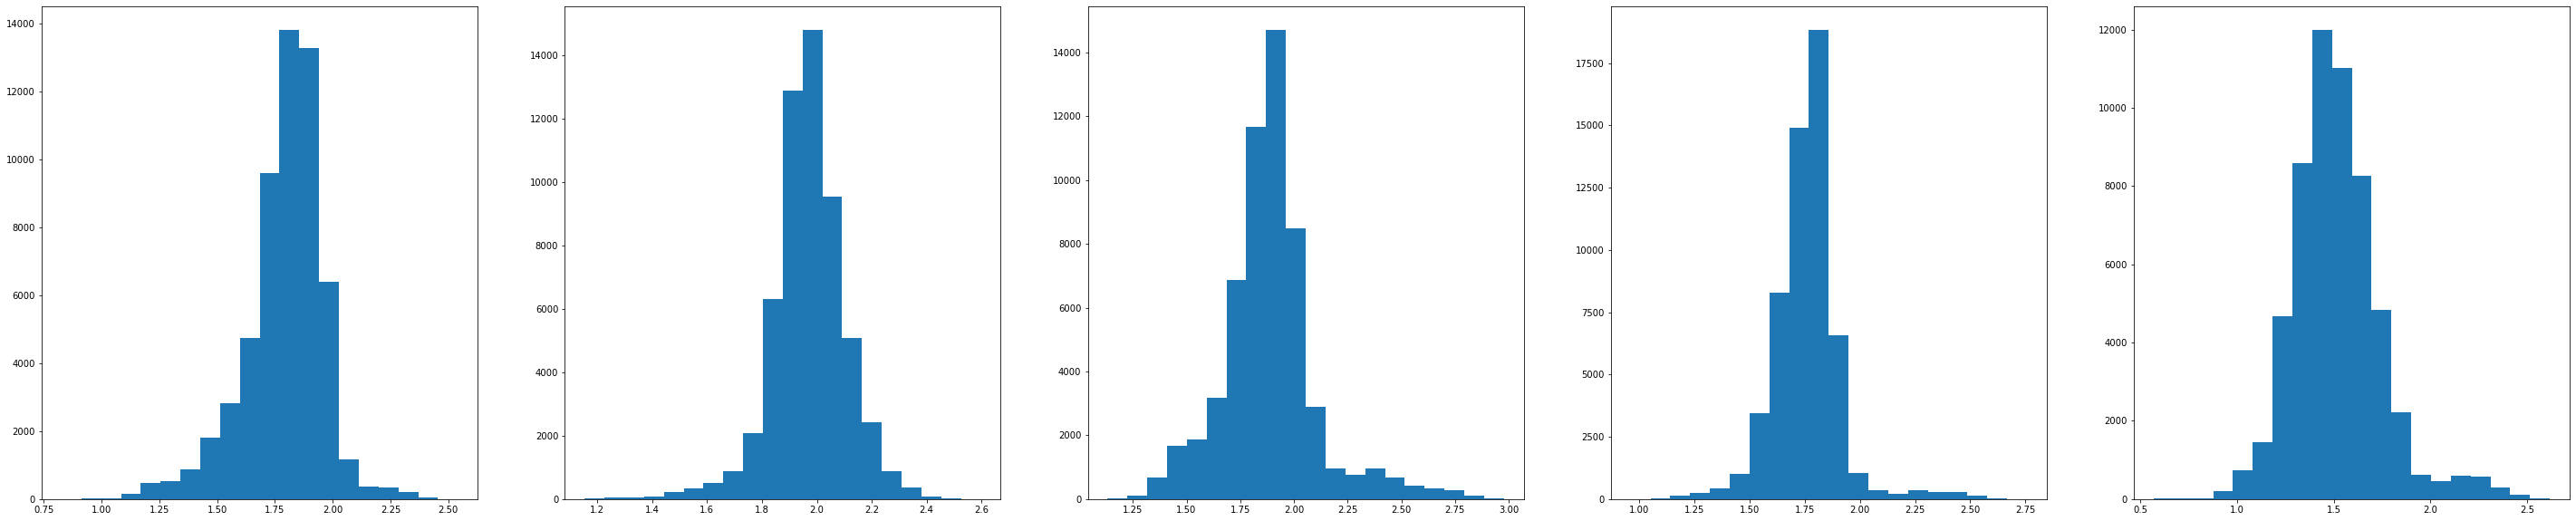

In [65]:
f, axs = plt.subplots(1, 5, figsize=(50, 10))
for ax, idx in zip(axs, sbs):
    ax.hist(down[:, idx], bins=20)

## up state

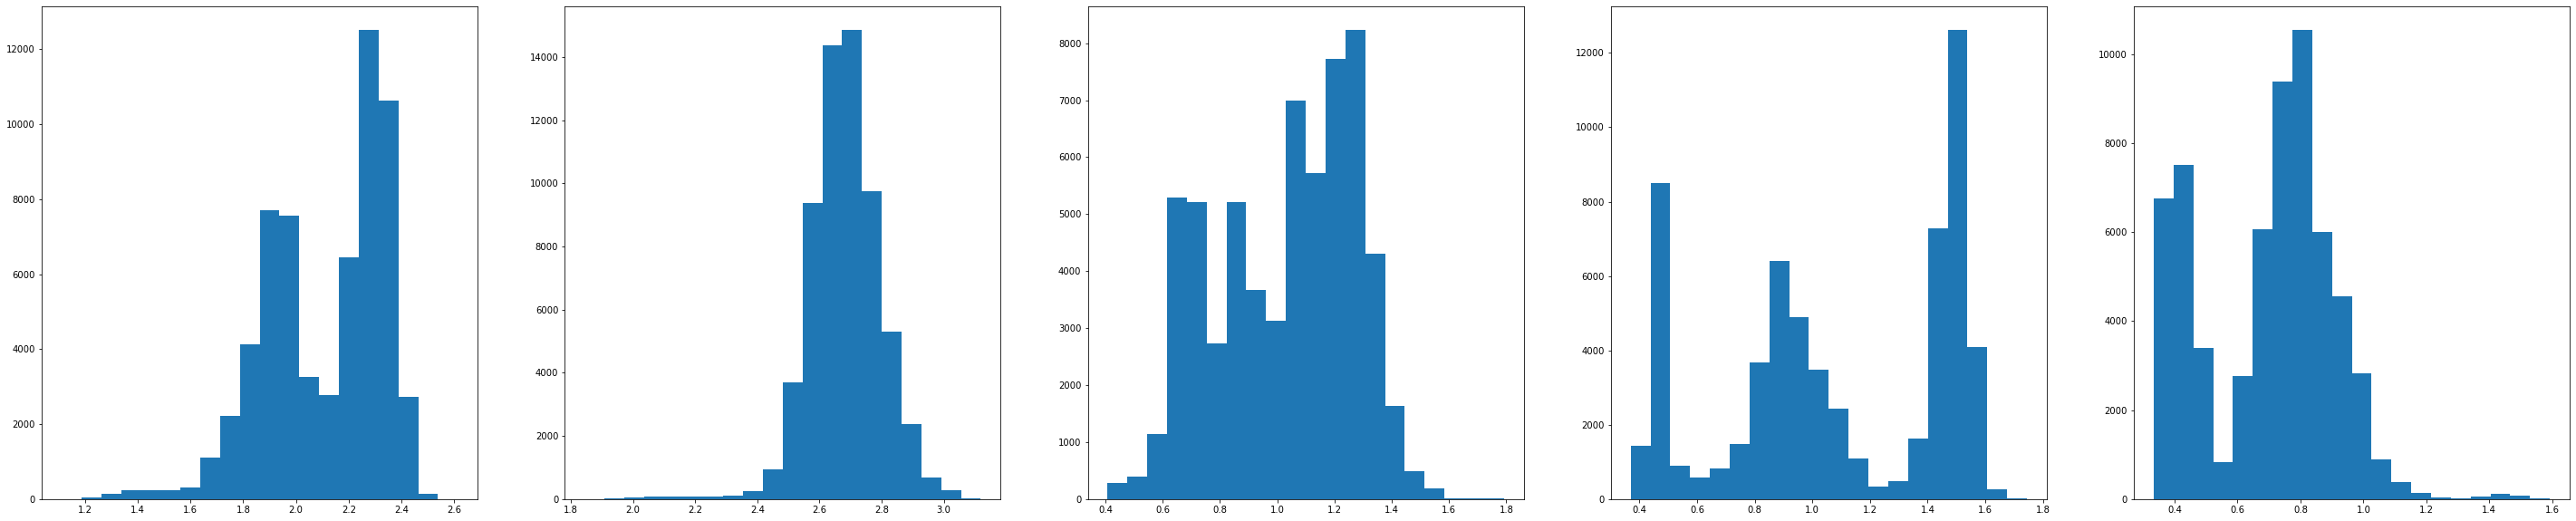

In [66]:
f, axs = plt.subplots(1, 5, figsize=(50, 10))
for ax, idx in zip(axs, sbs):
    ax.hist(up[:, idx], bins=20)

interesting variation in SB3 - which is R229 - D129 (maybe has to dow with the lagging at the hydrophobic plug)

## up plus state 

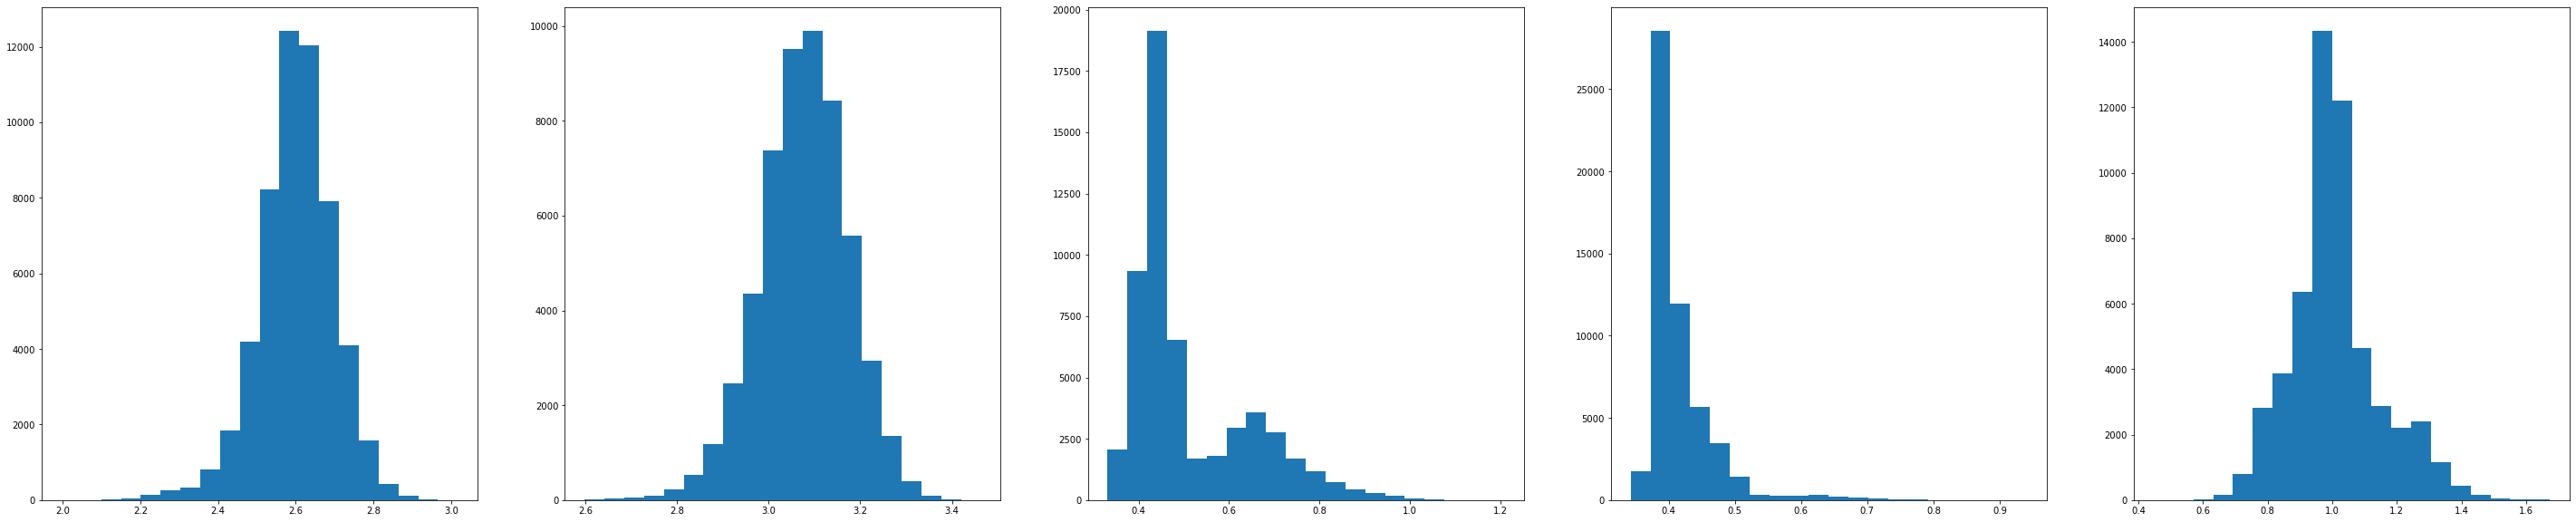

In [67]:
f, axs = plt.subplots(1, 5, figsize=(50, 10))
for ax, idx in zip(axs, sbs):
    ax.hist(upplus[:, idx], bins=20)

## Combined

### picked salt bridges 

In [82]:
import seaborn as sns

In [103]:
plt.style.use("seaborn-ticks")

In [97]:
sns.set_palette("colorblind")

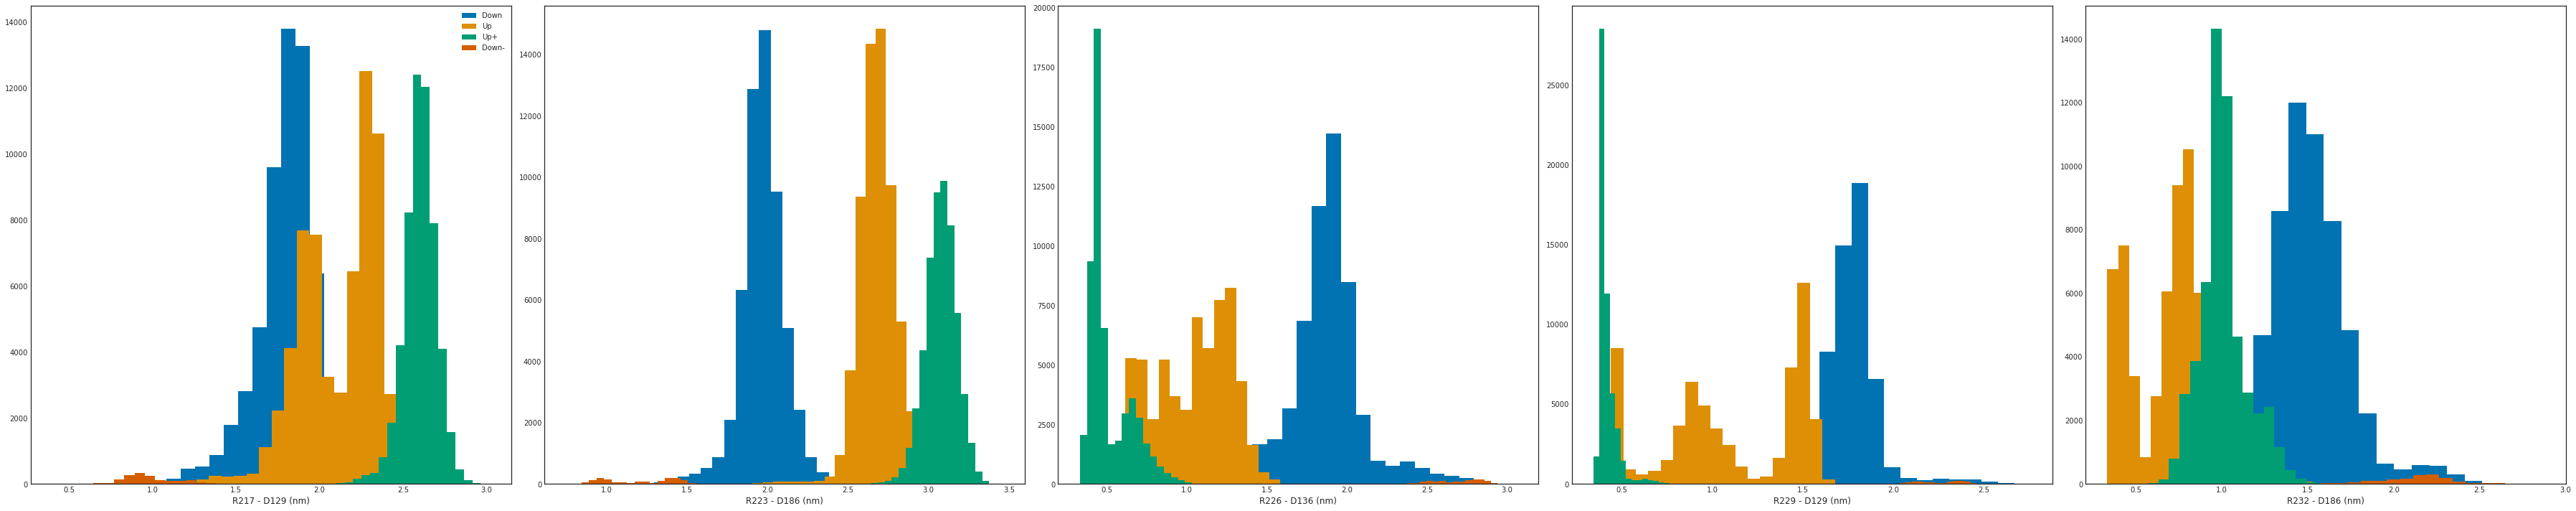

In [100]:
f, axs = plt.subplots(1, 5, figsize=(50, 10))
for ax, idx in zip(axs, sbs):
    ax.hist(down[:, idx], bins=20)
    ax.hist(up[:, idx], bins=20)
    ax.hist(upplus[:, idx], bins=20)
    ax.hist(downmin[:, idx], bins=20)
    ax.set_xlabel(f"{sb_labels[idx - 30]} (nm)")

axs[0].legend(["Down", "Up", "Up+", "Down-"])
f.tight_layout()
f.savefig("../../fig/sb0-4_4states_histogram", dpi=300)

Yeah something strange with the up state - should include some kind of cutoff on the salt bridge distances perhaps

According to the crystal structure, the R3 should be near/paired with D129 so I assume the right most peak in the SB3 histogram (orange) is the lag

same thing with up plus in SB2 (R2/R226 - D136)

### average salt bridges 

In [42]:
sb_avgs_down = [sb_avg[down_ids] for sb_avg in sb_avgs]
sb_avgs_up = [sb_avg[up_ids] for sb_avg in sb_avgs]
sb_avgs_downmin = [sb_avg[downmin_ids] for sb_avg in sb_avgs]
sb_avgs_upplus = [sb_avg[upplus_ids] for sb_avg in sb_avgs]

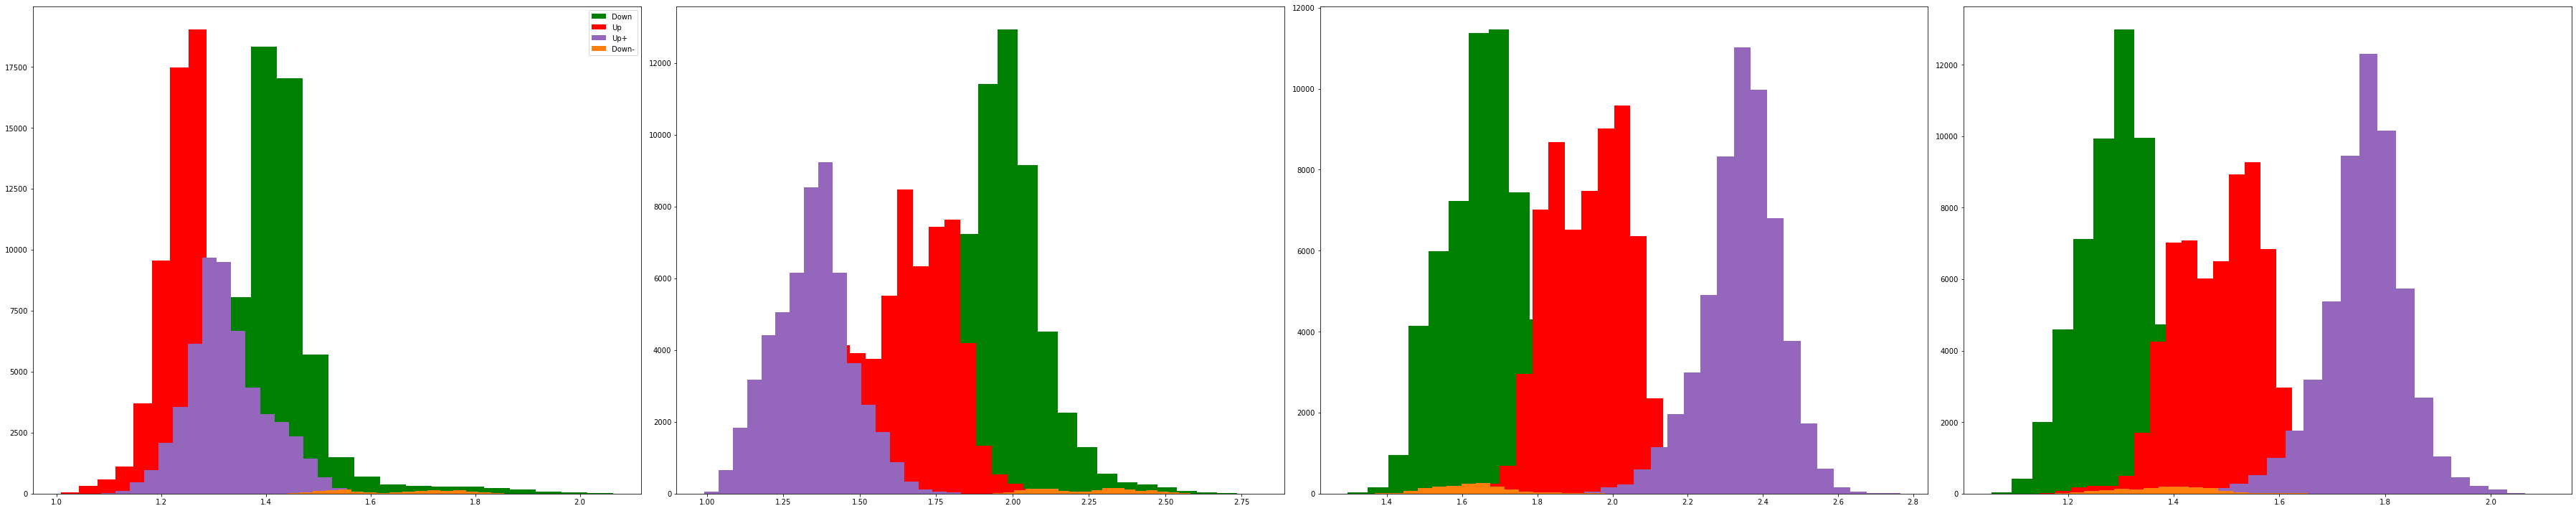

In [45]:
f, axs = plt.subplots(1, 4, figsize=(50, 10))

for ax, down, up, upplus, downmin in zip(
    axs, sb_avgs_down, sb_avgs_up, sb_avgs_upplus, sb_avgs_downmin
):
    ax.hist(down, color="g", bins=20)
    ax.hist(up, color="r", bins=20)
    ax.hist(upplus, color="C4", bins=20)
    ax.hist(downmin, color="C1", bins=20)

axs[0].legend(["Down", "Up", "Up+", "Down-"])
f.tight_layout()

everything except down state looks nice - maybe the distances to D129 (left) aren't as different

In [19]:
data_arr.shape

(6580000, 60)

(-10.0, 10.0)

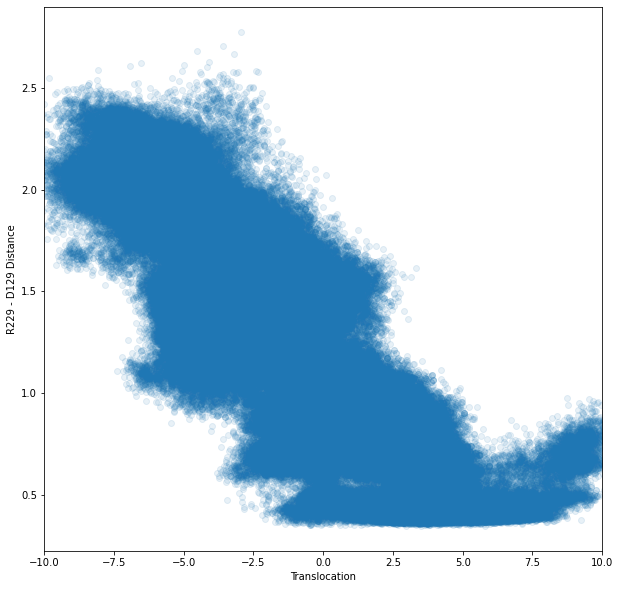

In [23]:
f = plt.figure(figsize=(10, 10))
plt.scatter(cvs[::10, 0], data_arr[::10, sbs[3]], alpha=0.1)
plt.xlabel("Translocation")
plt.ylabel("R229 - D129 Distance")
plt.xlim([-10, 10])

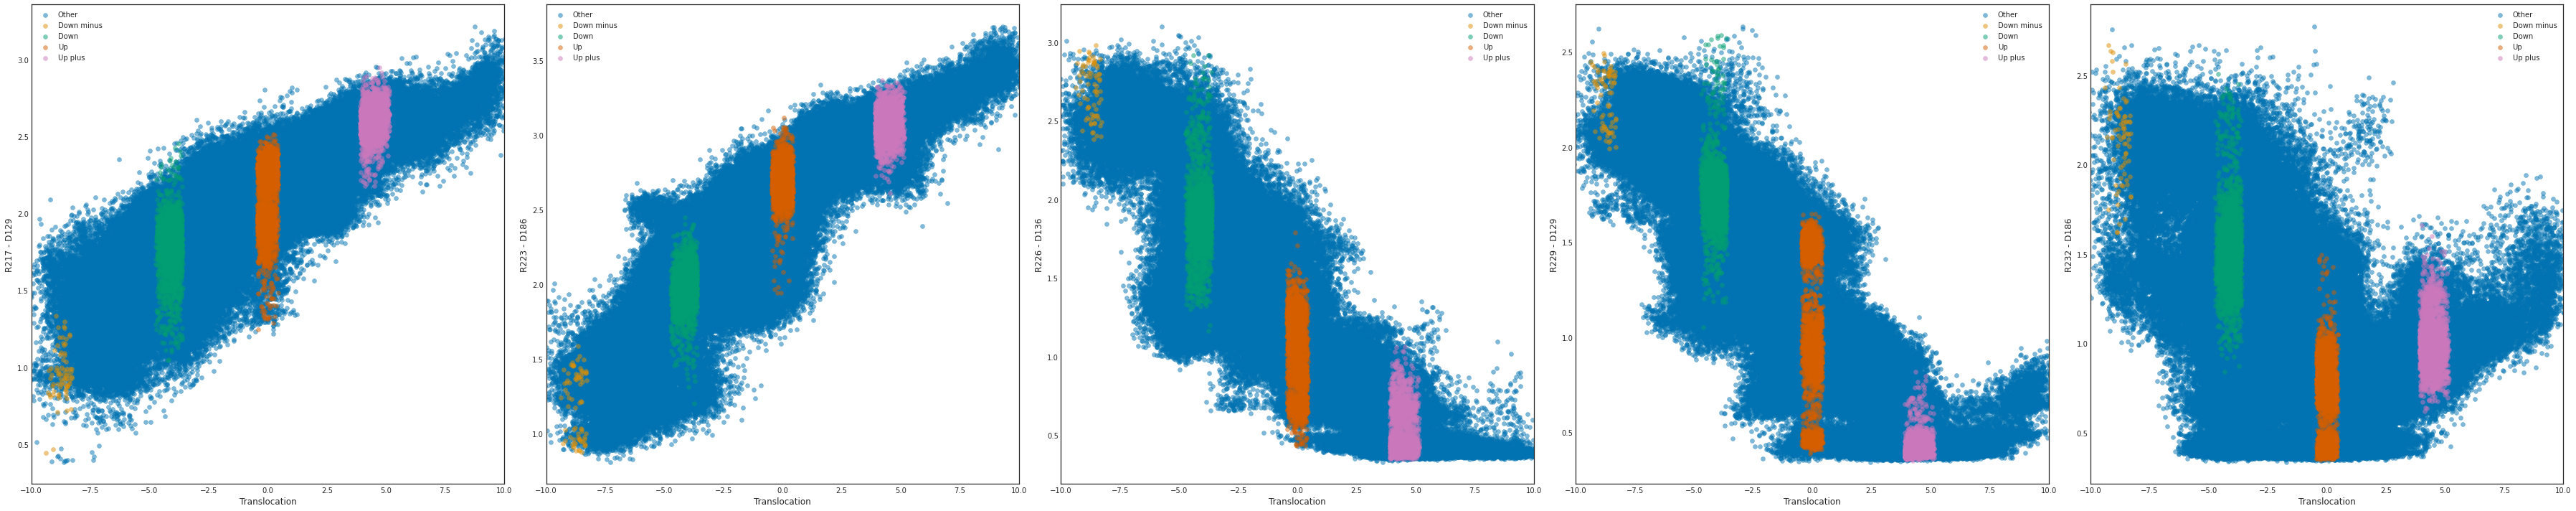

In [99]:
f, axs = plt.subplots(1, 5, figsize=(50, 10))
for ax, idx in zip(axs, sbs):
    for cv_group, sb_group in zip(
        (other_cvs, downmin_cvs, down_cvs, up_cvs, upplus_cvs),
        (other, downmin, down, up, upplus),
    ):
        ax.scatter(cv_group[::20, 0], sb_group[::20, idx], alpha=0.5)

    ax.legend(["Other", "Down minus", "Down", "Up", "Up plus"])
    ax.set_xlim([-10, 10])
    ax.set_xlabel("Translocation")
    ax.set_ylabel(sb_labels[idx - 30])

f.tight_layout()

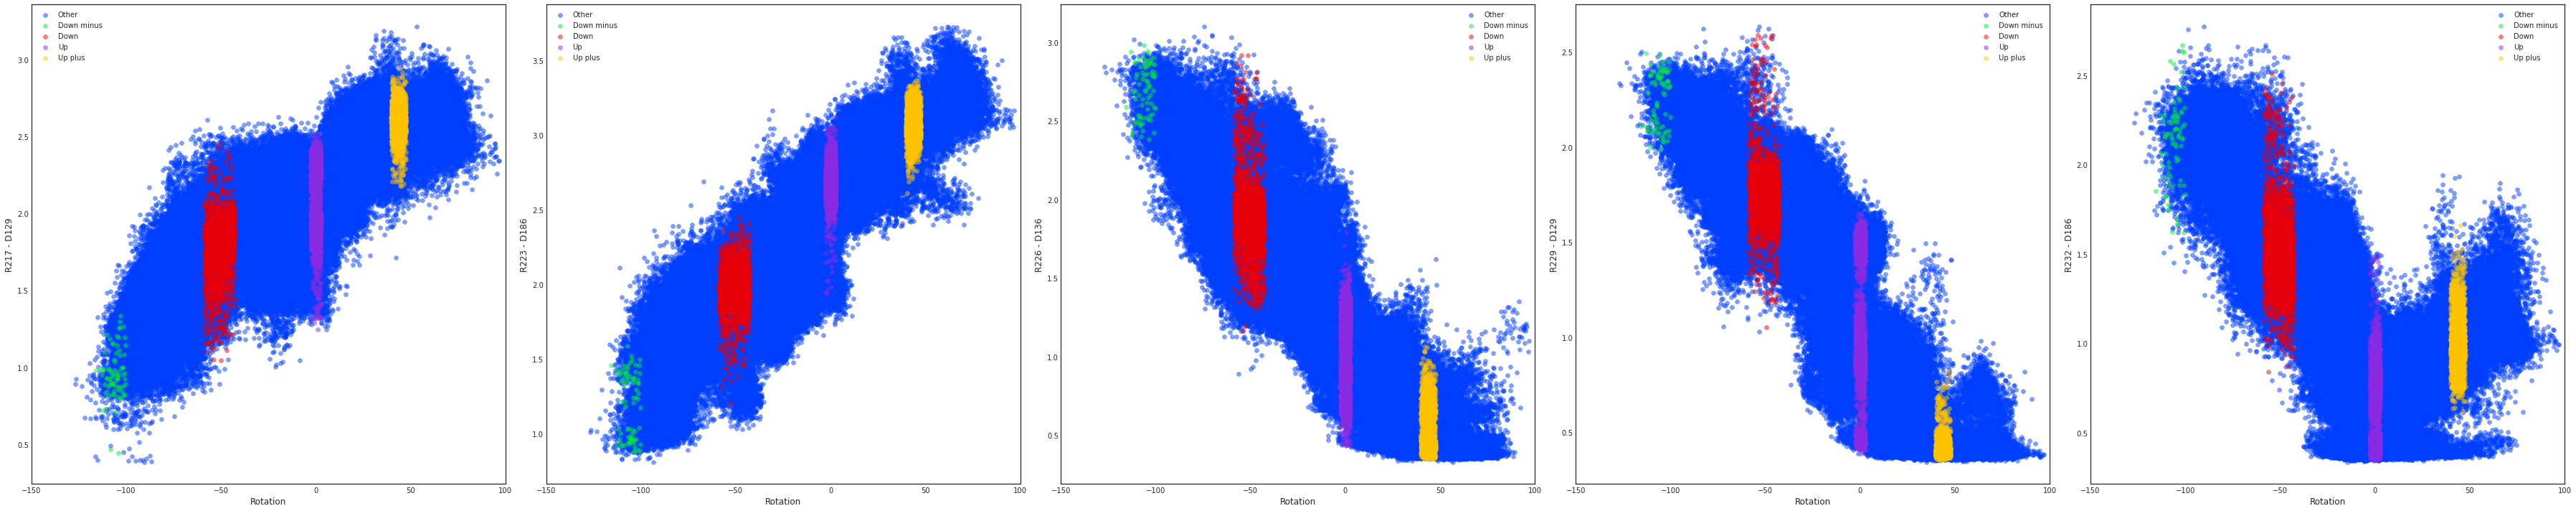

In [93]:
f, axs = plt.subplots(1, 5, figsize=(50, 10))
for ax, idx in zip(axs, sbs):
    for cv_group, sb_group in zip(
        (other_cvs, downmin_cvs, down_cvs, up_cvs, upplus_cvs),
        (other, downmin, down, up, upplus),
    ):
        ax.scatter(cv_group[::20, 1], sb_group[::20, idx], alpha=0.5)

    ax.legend(["Other", "Down minus", "Down", "Up", "Up plus"])
    ax.set_xlim([-150, 100])
    ax.set_xlabel("Rotation")
    ax.set_ylabel(sb_labels[idx - 30])

f.tight_layout()

In [62]:
# what are the points corresponding to the 3 peaks for the up state and the 2 peaks in the up plus state in the SB3 plot?
dist_up = ((up[:, sbs[3]] - 1.5) ** 2).argsort()
dist_up_2 = ((up[:, sbs[3]] - 1.0) ** 2).argsort()
dist_up_3 = ((up[:, sbs[3]] - 0.5) ** 2).argsort()
dist_upp = ((upplus[:, sbs[2]] - 0.4) ** 2).argsort()
dist_upp_2 = ((upplus[:, sbs[2]] - 0.64) ** 2).argsort()

In [74]:
up_ids[dist_up][:30]

array([6284296, 6139999, 6409999, 6419999, 6389999, 6259999, 6299999,
       6414713, 6384713, 6254713, 6294713, 6134713, 6404713, 6281124,
       6386494, 6136494, 6416494, 6406494, 6296494, 6256494, 6284017,
       3764197, 6392373, 6362373, 6192373, 5742373, 2944105, 5847774,
       6257815, 6407815])

Trajectory 981, frame 1105 (2944105) shows that the R229 is pointing below the hydrophobic plug, which is the crystal up structure (distance of SB3 ~15 angstroms). Suggests that the wide distribution of lower values (less than 10 angstroms) are actually structure which have the R229 above the plug, closer to the up+ crystal model - making salt bridge with D183.

In [73]:
up_ids[dist_up_2][:10]

array([2934033, 2508990, 2195759, 2376528, 2403656,  978005, 2496870,
       2101115,  295175, 2346955])

Trajectory 978, Frame 33: R229 is "lodged" inside the plug - not above, and maybe the D129 is a little bit lower

In [75]:
up_ids[dist_up_3][:10]

array([3826349, 3825273,  381179, 3836039, 1436337, 1703817,  835887,
       3827925, 3833938, 1737306])

Trajectory 127, Frame 179: R229 almost above, but not quite

In [77]:
upplus_ids[dist_upp[:10]]

array([3426483,  538744,  435096, 2606059, 1205157,  490625,  751681,
       4421914, 3999710, 1724353])

Trajectory 179, frame 1744: Looks like a fairly normal Up-plus state, perhaps teh rotation is not as advanced as in the model, but the R226 is pointing basically straight up, which puts it nearer the D136 salt bridge partner

In [78]:
upplus_ids[dist_upp_2[:10]]

array([3474486, 4399501, 4377134, 3471155, 3454888, 3470048, 3945015,
       3941348, 2382345, 4484087])

Trajectory 794, Frame 345: rotated further upwards and away from S1

In [79]:
# how about points which are the SB4, up state

In [80]:
dist_up_4_high = ((up[:, sbs[4]] - 0.8) ** 2).argsort()
dist_up_4_low = ((up[:, sbs[4]] - 0.4) ** 2).argsort()
print(up_ids[dist_up_4_high[:10]])
print(up_ids[dist_up_4_low[:10]])

[6412020 6402020 6252020 6382020 6292020 6132020 1896008 6132034 6252034
 6402034]
[1588059 2400507  645085  338334  953205  309990 2791568 2508563 2949723
 2945122]


Trajecotry 632, frame 8: R232 seems rotated down and away from E183, further from the crystal structure position where it can make both salt bridgees with E183 and E186

Trajectory 529, frame 1059: 

In [105]:
# wide distribution of SB2, up state
dist_up_2_06 = ((up[:, sbs[2]] - 0.6) ** 2).argsort()
dist_up_2_08 = ((up[:, sbs[2]] - 0.8) ** 2).argsort()
dist_up_2_14 = ((up[:, sbs[2]] - 1.4) ** 2).argsort()
print(up_ids[dist_up_2_06[:10]])
print(up_ids[dist_up_2_08[:10]])
print(up_ids[dist_up_2_14[:10]])

[2363335 2123401 2872332 3829146 1898466 2123059 1897514 2816797  836421
 3828027]
[ 306962 2951476 3839032 2102525 3825096 2677995 6260219 6010219 6240219
 6170219]
[4854306 1324145 6285672 4227581 6288164 5592893 5782893 4857975 6285406
 6392936]


In [ ]:
Trajectory 787, 2335

### labels 

In [33]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "D186", "E183"):
        sb_labels.append(f"{r} - {n}")

## Refined up-plus state 

In [ ]:
# ellipse centered at (4.535, 43.7) with radii 0.632 and 2.9 for up+ state

upplus_ids = (
    (((dist - 4.535) / 0.632) ** 2 + ((rot - 43.7) / 4.0) ** 2) < 1
).nonzero()[0]